# Autoencoder for time series

Import libreries for build and run the model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from tensorflow.contrib.rnn import LSTMCell
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD


In [2]:
# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm = True, ratio_train = 0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]

In [3]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData('../data/UCRArchive_2018', 'ECG5000')

## Config time

In [4]:
config = dict()
config = dict()  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64 # number of samples for iteration
config['learning_rate'] = .005 # for exponential decay
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 20 # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8 # Dropout rate

Valuate sequence length

In [5]:
dataTrain.shape[0]
N = dataTrain.shape[0]
Nval = dataTest.shape[0]
D = dataTrain.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

We have 3999 observations with 140 dimensions


Valuate class number and min class

In [6]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 5 classes, 1.0 is the min class value


In [7]:
# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(X_train, y_train, plot_row=5, save = False, name = 'tmp.eps'):
    counts = dict(Counter(y_train))
    num_classes = len(np.unique(y_train))
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):  # Loops over classes, plot as columns
        c = int(c)
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            axarr[n, c].plot(X_train[ind_plot[n], :])
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, c].set_title('Class %.0f (%.0f)' % (c, counts[float(c)]))
            if not n == plot_row - 1:
                plt.setp([axarr[n, c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n, c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  # No horizontal space between subplots
    f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='eps', dpi=1000)
        
    return


Populating the interactive namespace from numpy and matplotlib


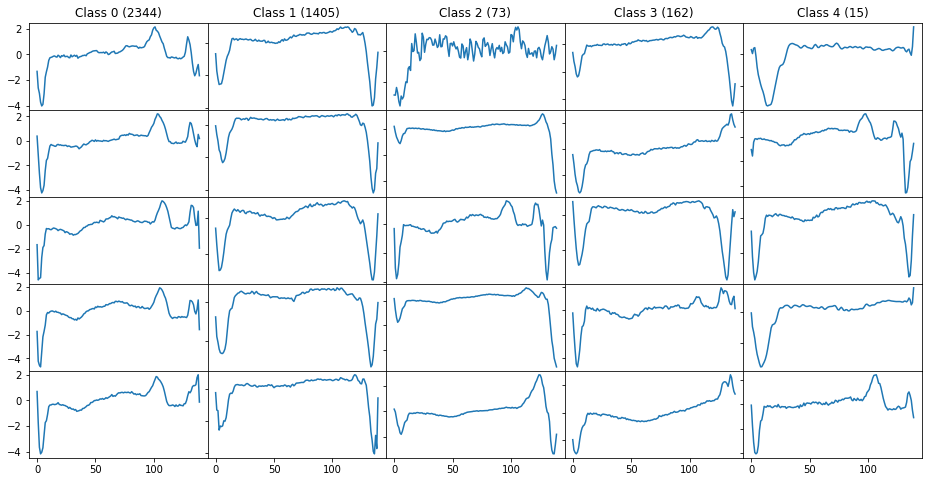

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain)
# plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

## Training time

In [9]:
class Model:
    def __init__(self, config):
        # Hyperparameters of the net
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        sl = config['sl']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.sl = sl
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, sl], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = tf.placeholder("float")

        with tf.variable_scope("Encoder"):
            # Th encoder cell, multi-layered with dropout
            cell_enc = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=self.keep_prob)

            # Initial state
            initial_state_enc = cell_enc.zero_state(batch_size, tf.float32)

            # with tf.name_scope("Enc_2_lat") as scope:
            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            outputs_enc, _ = tf.contrib.rnn.static_rnn(cell_enc,
                                                       inputs=tf.unstack(self.x_exp, axis=2),
                                                       initial_state=initial_state_enc)
            cell_output = outputs_enc[-1]
            b_mu = tf.get_variable('b_mu', [num_l])

            # For all intents and purposes, self.z_mu is the Tensor containing the hidden representations
            # I got many questions over email about this. If you want to do visualization, clustering or subsequent
            #   classification, then use this z_mu
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec"):
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        with tf.variable_scope("Decoder"):
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * sl
            # outputs_dec, _ = tf.nn.seq2seq.rnn_decoder(dec_inputs, initial_state_dec, cell_dec)
            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer"):
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [sl*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [sl, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tf.contrib.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train"):
            # Use learning rte decay
            global_step = tf.Variable(0, trainable=False)
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients so that we can plot them on Tensorboard
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)
            #      for gradient, variable in gradients:  #plot the gradient of each trainable variable
            #        if isinstance(gradient, ops.IndexedSlices):
            #          grad_values = gradient.values
            #        else:
            #          grad_values = gradient
            #
            #        self.numel +=tf.reduce_sum(tf.size(variable))
            #        tf.summary.histogram(variable.name, variable)
            #        tf.summary.histogram(variable.name + "/gradients", grad_values)
            #        tf.summary.histogram(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))

            self.numel = tf.constant([[0]])
        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # and one op to initialize the variables
        self.init_op = tf.global_variables_initializer()

In [10]:
model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))

batch_size = config['batch_size']

# Start of the train
epochs = np.floor(batch_size * max_iterations / N)

print('Train with approximately %d epochs' % epochs)

sess.run(model.init_op)

step = 0  # Step is a counter for filling the numpy array perf_collect
for i in range(max_iterations):
    batch_ind = np.random.choice(N, batch_size, replace=False)
    result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                      feed_dict={model.x: dataTrain[batch_ind], model.keep_prob: dropout})
    
    if i % plot_every == 0:
        # Save train performances
        perf_collect[0, step] = loss_train = result[0]
        loss_train_seq, lost_train_lat = result[1], result[2]

        # Calculate and save validation performance
        batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                          feed_dict={model.x: dataTest[batch_ind_val], model.keep_prob: 1.0})
        perf_collect[1, step] = loss_val = result[0]
        loss_val_seq, lost_val_lat = result[1], result[2]
        # and save to Tensorboard
        summary_str = result[3]

        print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
        i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
        step += 1
    
saver = tf.train.Saver()
saver.save(sess, os.path.join("logs/ecg5000.ckpt"), step)

print("model trained")

W0711 00:51:20.807508 139957035218560 deprecation.py:323] From <ipython-input-9-26ab09170a6a>:22: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0711 00:51:20.808447 139957035218560 deprecation.py:323] From <ipython-input-9-26ab09170a6a>:22: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0711 00:51:20.824259 139957035218560 deprecation.py:506] From /home/flavio/Universita/Progetto-Data-science/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a f

Train with approximately 16 epochs
At      0 /   1000 train (3.796, 1.949, 1.848), val (3.181, 1.851,1.330) in order (total, seq, lat)
At    100 /   1000 train (0.878, 0.868, 0.010), val (0.784, 0.779,0.005) in order (total, seq, lat)
At    200 /   1000 train (0.558, 0.551, 0.006), val (0.816, 0.815,0.000) in order (total, seq, lat)
At    300 /   1000 train (0.795, 0.789, 0.006), val (0.587, 0.581,0.006) in order (total, seq, lat)
At    400 /   1000 train (0.386, 0.378, 0.008), val (0.720, 0.715,0.005) in order (total, seq, lat)
At    500 /   1000 train (0.486, 0.480, 0.006), val (0.405, 0.402,0.003) in order (total, seq, lat)
At    600 /   1000 train (0.333, 0.326, 0.008), val (0.473, 0.467,0.006) in order (total, seq, lat)
At    700 /   1000 train (0.369, 0.363, 0.006), val (0.412, 0.410,0.002) in order (total, seq, lat)
At    800 /   1000 train (0.237, 0.230, 0.008), val (0.509, 0.505,0.004) in order (total, seq, lat)
At    900 /   1000 train (0.163, 0.155, 0.008), val (0.293, 0.291

In [11]:
def plot_z_run(z_run, label, ):
    f1, ax1 = plt.subplots(2, 1)

    # First fit a PCA
    PCA_model = TruncatedSVD(n_components=3).fit(z_run)
    z_run_reduced = PCA_model.transform(z_run)
    ax1[0].scatter(z_run_reduced[:, 0], z_run_reduced[:, 1], c=label, marker='*', linewidths=0)
    ax1[0].set_title('PCA on z_run')

    # THen fit a tSNE
    tSNE_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000)
    z_run_tsne = tSNE_model.fit_transform(z_run)
    ax1[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=label, marker='*', linewidths=0)
    ax1[1].set_title('tSNE on z_run')

    plt.show()
    return

In [19]:
saver = tf.train.Saver()
saver.restore(sess, save_path=os.path.join("logs/ecg5000.ckpt-0"))

start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size
    
z_mu_fetch[0]

array([ 0.28643167, -1.3337502 ,  0.3841508 , -1.6105129 , -0.4109673 ,
        0.55764735,  0.70682114,  1.3558397 ,  0.5032728 ,  0.79647684,
       -0.80102396, -0.05415465, -0.15034878, -0.94567436, -1.5711588 ,
       -1.4836069 ,  0.5979006 ,  0.517067  ,  0.9877245 ,  1.7409855 ],
      dtype=float32)

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(z_mu_fetch)
kmeans.labels_ +=1
kmeans.labels_
kmeans.cluster_centers_


array([[-0.30180445, -0.592891  ,  0.8437061 , -0.45575735,  0.5294384 ,
         0.3931734 ,  0.67782915,  0.31741294, -0.9705511 , -0.13023598,
        -0.7887571 , -0.73742414,  0.01497562,  1.7740309 , -0.13996455,
        -1.5828577 , -1.8511827 ,  1.0992006 ,  1.6550989 ,  0.21474737],
       [ 0.68804395, -1.3087392 ,  0.55508363, -1.4636996 , -0.37170517,
         0.2574734 ,  0.40897864,  0.9469259 ,  1.0467064 ,  0.6243762 ,
        -0.7672052 ,  0.15560007, -0.3094814 , -0.9527257 , -1.5452281 ,
        -1.2595575 ,  0.7505709 ,  0.3521672 ,  0.7569681 ,  1.4456122 ],
       [ 0.28732342, -0.7672893 ,  1.5645773 , -0.39581096,  0.2578227 ,
        -0.44834417,  0.6695429 ,  0.8096724 , -0.47993296, -0.23386069,
        -1.3642945 , -0.55183834, -0.82075495,  1.473398  , -0.2612608 ,
        -1.4804419 , -1.2545662 ,  0.8321701 ,  1.8450651 ,  0.38906386],
       [-0.27005398, -0.6532675 ,  0.70853525, -1.1212311 , -0.14300299,
         0.7213055 ,  0.83084327,  1.16349   , -

In [ ]:
# Extract the latent space coordinates of the validation set
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size

z_run = np.concatenate(z_run, axis=0)
label = labelsTest[:start]

plot_z_run(z_run, label)

#sess.close()